<a href="https://colab.research.google.com/github/yuraoh12/AI-bigdata/blob/main/240104_Chroma_Vector_Database_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chroma Vector Database Tutorial

빠른 이미지 검색을 위한 벡터 데이터베이스 튜토리얼

In [ ]:
!pip install -q chromadb transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9/698.9 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.6

## Dataset

Food-11 데이터셋 중 evaluation 데이터 10장씩

https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [ ]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

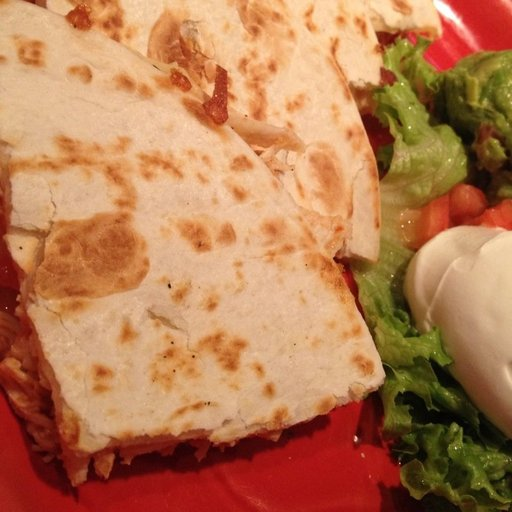

In [ ]:
from PIL import Image

img = Image.open("test/Bread/0.jpg")

img

## Image Vectorizer 모델 로드

https://huggingface.co/facebook/dino-vits16

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to("cuda")

print("Models loaded!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded!


## 임베딩

In [ ]:
img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

embedding

In [ ]:
embedding.shape

(384,)

## Chroma DB 시작

https://www.trychroma.com

In [ ]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods")

## 모든 이미지 벡터화

In [ ]:
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

len(img_list)

110

In [ ]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)):
    img = Image.open(img_path)
    cls = img_path.split("/")[1]

    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()
    embedding_to_list = embedding.tolist()

    embeddings.append(embedding_to_list)

    metadatas.append({
        "uri": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

100%|██████████| 110/110 [00:02<00:00, 38.01it/s]

Done!


## 임베딩을 데이터베이스에 저장

In [ ]:
collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

## Test1

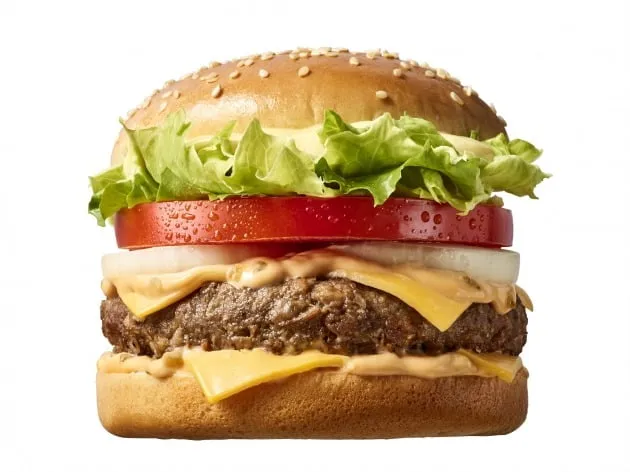

In [ ]:
import requests

test_img = Image.open(requests.get("https://i.imgur.com/yNp6qTS.png", stream=True).raw).convert("RGB")

test_img

In [ ]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
test_embedding_list = test_embedding.tolist()

test_embedding.shape

(384,)

In [ ]:
query_result = collection.query(
    query_embeddings=[test_embedding_list],
    n_results=3,
)

query_result

{'ids': [['8', '2', '108']],
 'distances': [[144.1071014404297, 248.98934936523438, 307.1300048828125]],
 'metadatas': [[{'name': 'Bread', 'uri': 'test/Bread/8.jpg'},
   {'name': 'Bread', 'uri': 'test/Bread/2.jpg'},
   {'name': 'Vegetable-Fruit', 'uri': 'test/Vegetable-Fruit/8.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None}

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["uri"]))
    axes[i].set_title(f"{metadata['name']}: {distance:.2f}")
    axes[i].axis("off")

## 테스트를 위한 함수화

In [ ]:
def query(img_url, n_results=3):
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding_list = test_embedding.tolist()

    query_result = collection.query(
        query_embeddings=[test_embedding_list],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["uri"]))
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i+1].axis("off")

    return query_result

## Test2

{'ids': [['47', '14', '86']],
 'distances': [[282.6903076171875, 296.8708190917969, 303.6256408691406]],
 'metadatas': [[{'name': 'Fried food', 'uri': 'test/Fried food/7.jpg'},
   {'name': 'Dairy product', 'uri': 'test/Dairy product/4.jpg'},
   {'name': 'Seafood', 'uri': 'test/Seafood/6.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None}

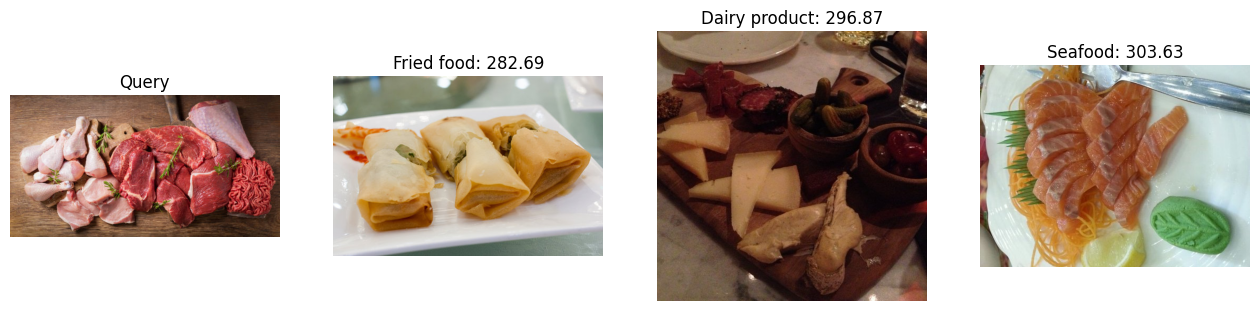

In [ ]:
query("https://i.imgur.com/QCado9g.jpg")

{'ids': [['13', '36', '14']],
 'distances': [[223.0016326904297, 229.2444610595703, 238.2934112548828]],
 'metadatas': [[{'name': 'Dairy product', 'uri': 'test/Dairy product/3.jpg'},
   {'name': 'Egg', 'uri': 'test/Egg/6.jpg'},
   {'name': 'Dairy product', 'uri': 'test/Dairy product/4.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None}

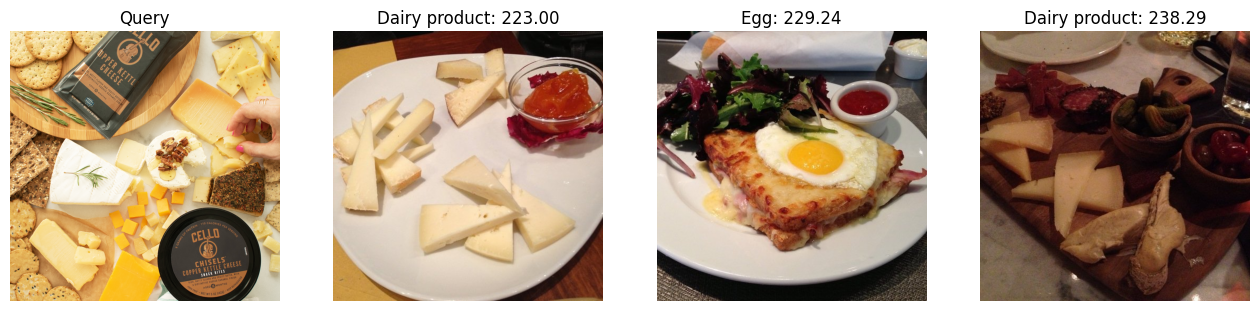

In [ ]:
query("https://i.imgur.com/lf5C0LI.png")

{'ids': [['77', '75', '72']],
 'distances': [[212.24978637695312, 226.03094482421875, 232.6399383544922]],
 'metadatas': [[{'name': 'Rice', 'uri': 'test/Rice/7.jpg'},
   {'name': 'Rice', 'uri': 'test/Rice/5.jpg'},
   {'name': 'Rice', 'uri': 'test/Rice/2.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None}

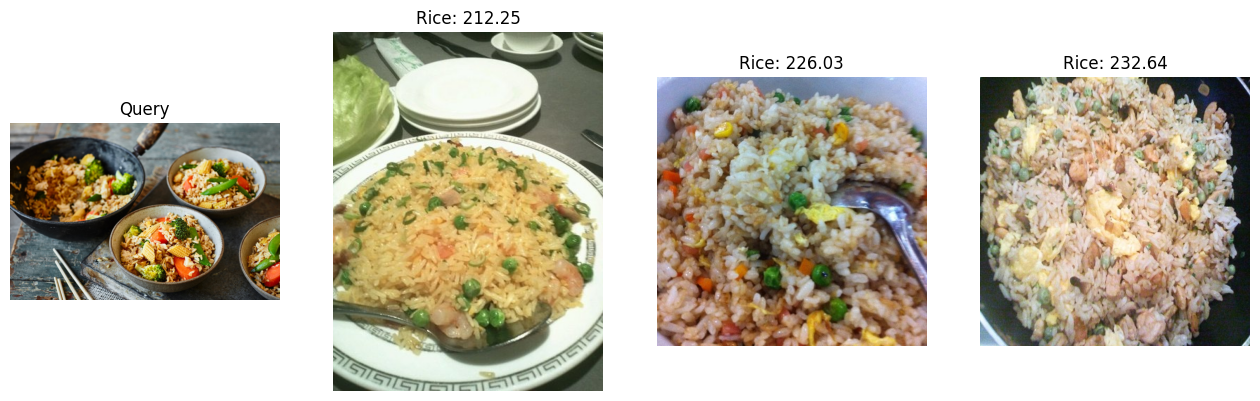

In [ ]:
query("https://i.imgur.com/WlLv0i9.png")